In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from scipy.stats import norm, multivariate_normal

#Ahora las funciones utiles de sklearn para preprocesar datos y armar un pipeline
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pp

from sklearn.model_selection import train_test_split 
from sklearn import metrics 

# Las estrellas de este notebook
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

from sklearn import datasets

# Iris dataset

Repasemos un poco que es el Iris Dataset

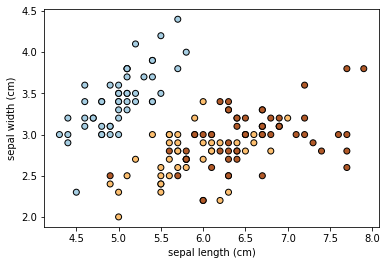

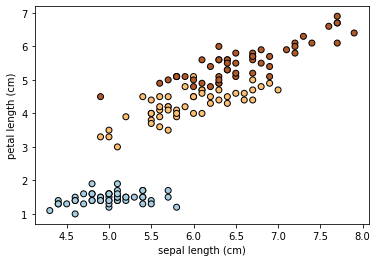

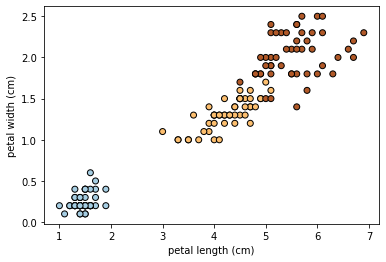

In [2]:
iris=datasets.load_iris()
X = iris.data
Y = iris.target

# Plot also the training points
for pair in ([0, 1], [0, 2], [2, 3]):
  plt.scatter(X[:, pair[0]], X[:, pair[1]], c=Y, edgecolors='k', cmap=plt.cm.Paired)
  plt.xlabel(iris.feature_names[pair[0]])
  plt.ylabel(iris.feature_names[pair[1]])
  plt.show()

# Naive Bayes

El objetivo de Naive Bayes es obtener un algoritmo de clasificacion bayesiano para espacios de sampleo de alta dimensionalidad que sea rapido y que pueda incorporar distintos tipos de mediciones con facilidad. Para eso, hace una hipotesis muy fuerte que limita su uso a ciertos problemas: **Naive Bayes asume que todas los features de una medicion $\vec{x}$ se samplean de manera independiente dada una clase $\mathcal{C}_k$.**

Dicho en ecuaciones, si yo sampleo una medicion $\vec{x}=(x_1,..,x_D)^{T}$ correspondiente a una clase $\mathcal{C}_k$:

$p(\vec{x}|\mathcal{C}_k)=\prod_{i=1}^{D}p(x_i| \mathcal{C}_k)$

Noten la condicionalidad con la clase. Esto no es lo mismo que decir que las features son independientes. Es decir, en general

$p(\vec{x})\neq\prod_{i=1}^{D}p(x_i)$

(Ya que esto implicaria que si tomamos a $\vec{x}$ como una variable gaussiana $D$-dimensional, su matriz de covarianza esta modelada como diagonal.)

Volviendo al caso general de Naive Bayes, este es un clasificador generativo en el que modelamos la verosimilitud, mientras que el prior se le pasa como dato. Una vez que tenemos el modelado, queremos ver cual es la probabilidad de asignar una nueva medicion $\vec{x}$ a una clase $\mathcal{C}_k$. Utilizando el teorema de Bayes:

$p(\mathcal{C}_k|\vec{x})=\frac{p(\vec{x}|\mathcal{C}_k)p(\mathcal{C}_k)}{p(\vec{x})}=\frac{\prod_{i=1}^{D}p(x_i|\mathcal{C}_k)p(\mathcal{C}_k)}{p(\vec{x})}$

Donde en la ultima igualdad se utilizo la condicion de independencia condicional. Una vez tenemos el conjunto de posteriores, asignamos a la medicion $\vec{x}$ la clase con el maximo posterior. Algo a mencionar es que este algoritmo no necesita calcular la evidencia de la medicion ya que este no es sensible al valor de $\mathcal{C}_k$. Por lo tanto, la clasificación se hace maximizando el numerador:

$\mathcal{C}_k = \text{argmax}_{k}\text{ }\prod_{i=1}^{D}p(x_i|\mathcal{C}_k)p(\mathcal{C}_k)$

El truco esta entonces en tener un buen modelo de la verosimilitud y pasarle un buen prior. Para construir la verosimilitud, lo mas comun es utilizar gaussianas para variables continuas:

$p(x_i|\mathcal{C}_k)=\mathcal{N}(x_i | \mu_{k,i}, \sigma_{k,i}^{2})$

Este es el modelo que utiliza el estimador `GaussianNB` de ``sklearn.naive_bayes``.

Para variables discretas, se debe definir que es $x_i$. Si decimos que $x_i$ representa la aparicion de $x_i$ veces el feature i-esimo en la muestra, (o, equivalentemente, que $\vec{x}$ sigue una distribucion multinomial) la verosimilitud se modela como:

$p(x_i|\mathcal{C}_k)=\theta_{k,i}^{x_i}$

Esto se utiliza en procesamiento de texto, en el que $theta_{k,i}$ representa la probabilidad de que aparezca la palabra i-esima $x_i$ veces en el texto $\vec{x}$. Este es el modelo que utiliza el estimador `MultinomialNB` de ``sklearn.naive_bayes``.

Mientras que si $x_i$ es una variable binaria, donde importa si aparece 1 o 0 veces (lo que es lo mismo que decir que $\vec{x}$ sigue una distribucion de Bernoulli multivariada), entonces:

$p(x_i|\mathcal{C}_k)=\theta_{k,i} x_i + (1-\theta_{k,i}) (1-x_i)$

Este es el modelo que utiliza el estimador `BernoulliNB` de ``sklearn.naive_bayes``. También, si le damos datos que originalmente no son binarios, podemos pedir que los vuelva binarios con un argumento.

Noten que en principio puedo tener variables continuas y discretas a la vez, ya que el modelo las trata de manera independiente sin problema. En particular, esto no esta implementando de buenas a primeras en `sklearn`.

Cualquiera de estas verosimilitudes tiene un conjunto de parametros libres que deben fittearse. Para eso, podemos utilizar el conjunto de entrenamiento $\vec{X}=(\vec{x}_1,...,\vec{x}_N)$, cada uno con su clase $\vec{T}=(\vec{t}_1,...,\vec{t}_N)$ (donde $\vec{t}_{i}$ es un vector con ceros en todos lados salvo en el lugar perteneciente a la clase de la medicion $\vec{x}_i$, donde hay un 1). Si escribimos el teorema de Bayes:

$p(\vec{T}|\vec{X})=\frac{p(\vec{X}|\vec{T})p(\vec{T})}{p(\vec{X})}$

Podemos sacar los parametros maximizanddo la verosimilitud, tomando priors uniformes.

Algo a tener en cuenta es que el Naive Bayes suele ser un buen clasificador pero un mal estimador de las densidades de probabilidad.

Veamos un ejemplo. Tomando el Iris dataset. Primero hagamos un clasificador simple en 2 dimensiones para ver el plot.

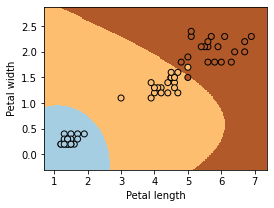

In [3]:
# import some data to play with
iris=datasets.load_iris()
X = iris.data[:, 2:]  # we only take the last two features.
Y = iris.target

h = .02  # step size in the mesh

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1) 
  
# training the model on training set 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
  
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()

Naive Bayes parece hacer las cosas bastante bien.

Algo distinto de Naive Bayes de, por ejemplo, Regresion Logistica, es que este es un modelo generativo. Es decir, tenemos tanto verosimilitud como posterior. 

En particular, dado que tenemos los parametros de maxima verosimilitud, podemos hacer deteccion de outliers. Para eso usamos que

$p(x)=\sum_{i=1}^{K}p(x|\mathcal{C}_{k})p(\mathcal{C}_{k}|\vec{X},\vec{T})$

Donde hice explicito el uso del entrenamiento para determinar la probabilidad de cada clase.

In [4]:
Sigma=gnb.sigma_
Mu=gnb.theta_
print(Mu.shape)
prior=gnb.class_prior_
print(prior)

(3, 2)
[0.34444444 0.32222222 0.33333333]


In [0]:
def prob(x):
  probaux=0.0
  for i in range(3):
    probaux+=multivariate_normal.pdf(x,mean=Mu[i],cov=Sigma[i])*prior[i]
  return probaux

Con esto ya podemos detectar cual es el dato mas anomalo de nuestro dataset de Training. 

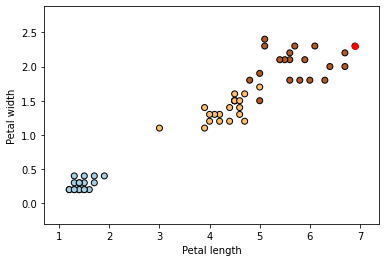

In [6]:
probtest=prob(X_test)
minprob=np.min(probtest)
anomalouest=X_test[np.where(probtest==minprob)]

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.scatter(anomalouest[0,0],anomalouest[0,1],color='Red',label='Most Anomalous One')
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()

En efecto, yo no estoy demasiado satisfecho. Para mi deberia ser el que esta cerca de (3,1.0). Pero tampoco hay que confiar demasiado en el Naive Bayes a la hora de estimar probabilidades. En efecto, grafiquemos la distribucion.

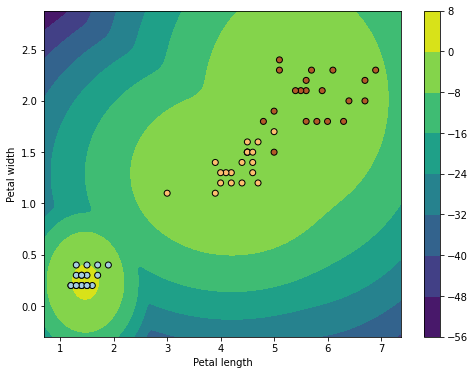

In [7]:
Z = np.log(prob(np.c_[xx.ravel(), yy.ravel()]))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.contourf(xx, yy, Z)
plt.colorbar()

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()

En efecto, el punto marcado como mas anomalo tiene sentido. Tambien pueden adivinarse las tres distribuciones $p(x|\mathcal{C}_{k})$ (dado que el prior es practicamente uniforme).

Ahora veamos el poder de clasificacion para todos los features.

In [8]:
  
# store the feature matrix (X) and response vector (y) 
X = iris.data 
y = iris.target 
  
# splitting X and y into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1) 
  
# training the model on training set 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
  
# making predictions on the testing set 
y_pred = gnb.predict(X_test) 
  
# comparing actual response values (y_test) with predicted response values (y_pred) 
from sklearn import metrics 
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 95.0


# Decision Trees


## Clasificacion 

Apliquemos esto al mismo dataset que antes:

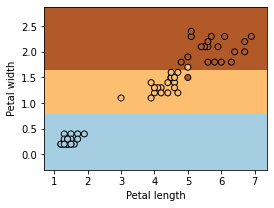

In [16]:
# import some data to play with
iris=datasets.load_iris()
X = iris.data[:, 2:]  # we only take the last two features.
Y = iris.target

h = .02  # step size in the mesh

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1) 
  
# training the model on training set 
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train, y_train)
  
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()


Vemos que las regiones son rectangulos. En particular, hay dos rectas de decision: una utiliza el length (depth=0) y la otra el width (depth=1). Si cambiamos el max depth del algoritmo, veriamos aparecer mas rectas correspondientes a decisiones binarias que hace el arbol. Podemos comprobar que hace exportando el arbol


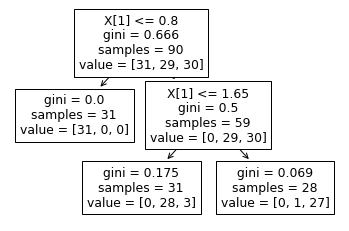

In [17]:
tree.plot_tree(tree_clf) 
plt.show()

O si quieren lo pueden exportar como un ".dot" y convertirlo a ".png" para la posteridad.

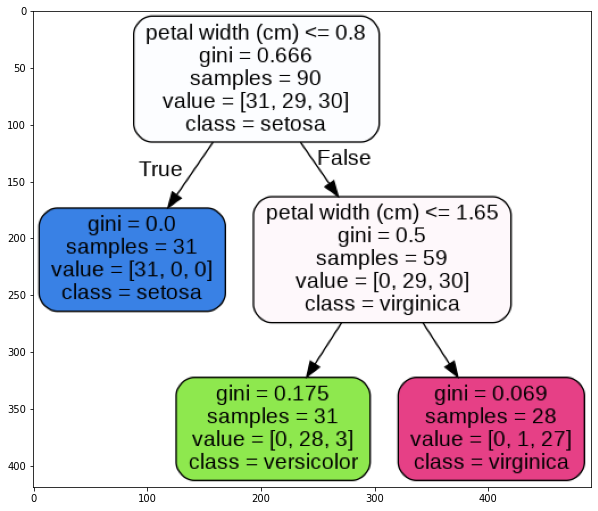

In [18]:
tree.export_graphviz(
tree_clf,
out_file="iris_tree.dot",
feature_names=iris.feature_names[2:],
class_names=iris.target_names,
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng iris_tree.dot -o iris_tree.png

#Ploteamos el png
img = cv2.imread('iris_tree.png')
plt.figure(figsize = (10, 10))
plt.imshow(img)

Ademas, el arbol puede dar una probabilidad. Esto lo hace viendo en que hoja termina la medicion y viendo la fraccion de eventos de cada clase que terminaron alli en el conjunto de entrenamiento.

In [19]:
print(tree_clf.predict_proba([[5, 1.5]]))
print(tree_clf.predict([[5, 1.5]]))

[[0.         0.90322581 0.09677419]]
[1]


El algoritmo tiene distintos parametros. En particular, podemos elegir si utiliza Gini o Entropia para calcular la impureza de un splitting. Generalmente no hay diferencia pero por definicion Gini puede favorecer mas la clase mas frecuente. La ventaja es que es mas rapida.

El arbol que encontro no es el optimo, pero es razonablemente bueno. Esta diferencia se hace mas pronunciada mientras mas profundo sea el arbol. Esto se debe a que la decision en que cada splitting no tiene en cuenta lo que pase en los splittings subsiguientes. Es lo que se llama un *greedy algorithm*.

Un gran problema con el Decision Tree que, al ser un modelo no parametrico, es propenso a overfittear. Por eso es necesario regularizarlo restringiendo la libertad del arbol. Las opciones que tenemos en sklearn son:


*   max_depth: por defecto es None, controla la profundidad del arbol.
*    min_samples_split: establece el minimo numero de muestras que debe tener un nodo para poder seguir partiendolo.
*    min_samples_leaf: el minimo numero de muestras que debe tener una hoja (ie nodo final).
*    min_weight_fraction_leaf: la minima fraccion pesada de muestras que debe poseer una hoja.
*    max_leaf_nodes: maxima cantidad de hojas.
*    max_features: maxima cantidad de features evaluados en un splitting.

Si uno sube los valores minimos o baja los maximos, esta restringiendo al arbol y regularizando el modelo.

Existen otros metodos de regularizacion como por ejemplo el pruning o podado de arboles en el que se entrena sin restricciones y luego se eliminan nodos innecesarios. 


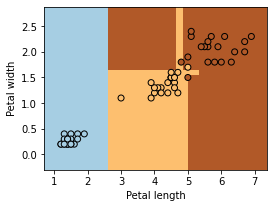

In [20]:
# import some data to play with
iris=datasets.load_iris()
X = iris.data[:, 2:]  # we only take the last two features.
Y = iris.target

h = .02  # step size in the mesh

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1) 
  
# training the model on training set 
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
  
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = tree_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()


Veamos el arbol

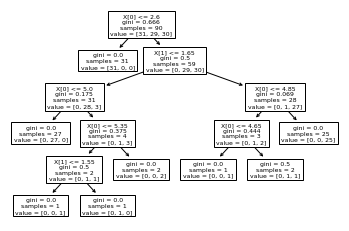

In [21]:
tree.plot_tree(tree_clf) 
plt.show()

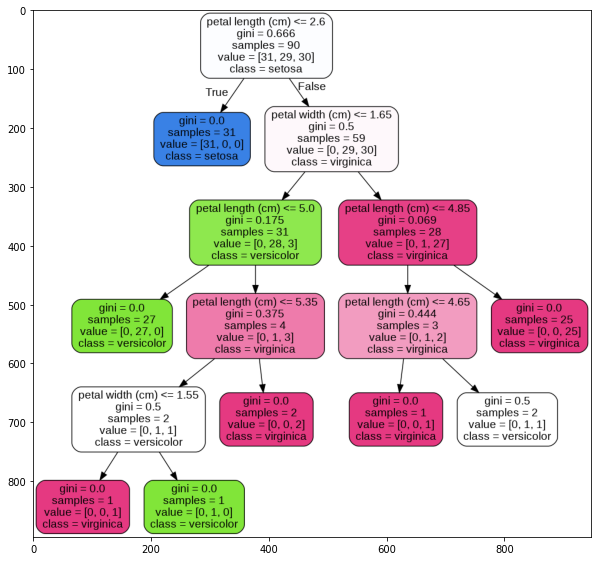

In [22]:
#Si lo quieren exportar:
tree.export_graphviz(
tree_clf,
out_file="iris_tree.dot",
feature_names=iris.feature_names[2:],
class_names=iris.target_names,
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng iris_tree.dot -o iris_tree.png

#Ploteamos el png
img = cv2.imread('iris_tree.png')
plt.figure(figsize = (10, 10))
plt.imshow(img)

En efecto, se ve un overfitting notorio.

Pero veamos que precision tienen en el caso tres dimensional.

In [23]:
# store the feature matrix (X) and response vector (y) 
X = iris.data 
y = iris.target 
  
# splitting X and y into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1) 
  
# training the model on training set 
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train, y_train)
  
# making predictions on the testing set 
y_pred = tree_clf.predict(X_test) 
  
# comparing actual response values (y_test) with predicted response values (y_pred) 
from sklearn import metrics 
print("Decission Tree model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Decission Tree model accuracy(in %): 96.66666666666667


Es mejor que el Naive Bayes!

Veamos la estructura de los trees.

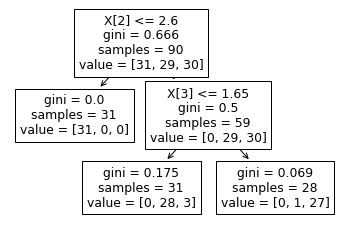

In [25]:
tree.plot_tree(tree_clf) 
plt.show()

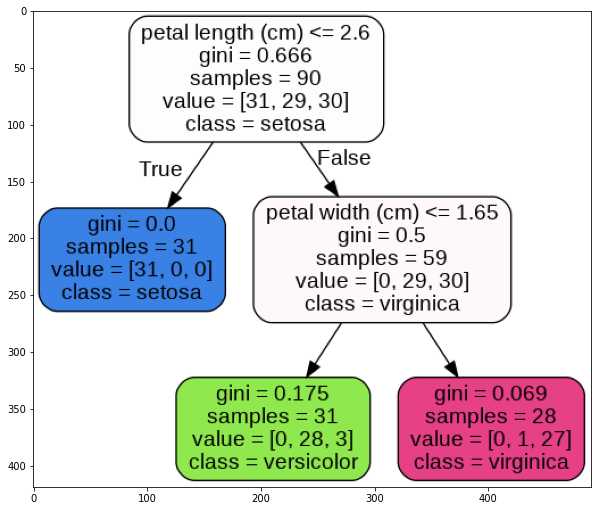

In [27]:
#Si lo queremos exportar
tree.export_graphviz(
tree_clf,
out_file="iris_tree.dot",
feature_names=iris.feature_names,
class_names=iris.target_names,
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng iris_tree.dot -o iris_tree.png
#Ploteamos el png
img = cv2.imread('iris_tree.png')
plt.figure(figsize = (10, 10))
plt.imshow(img)

## Regresion 

Veamos que hace un DecisionTree en el caso de Regresion. Aqui saco un ejemplo calcado de scikit-learn para jugar un poco


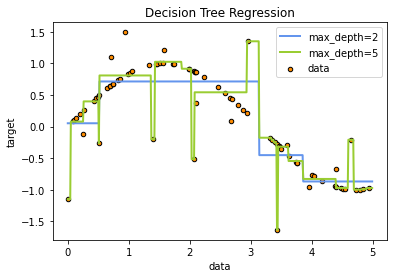

In [28]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Vemos que aumentar el depth aumenta el overfitting.

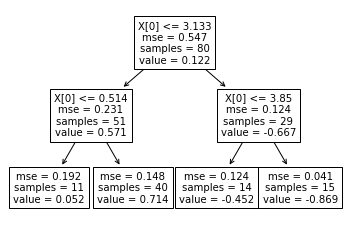

In [30]:
tree.plot_tree(regr_1) 
plt.show()

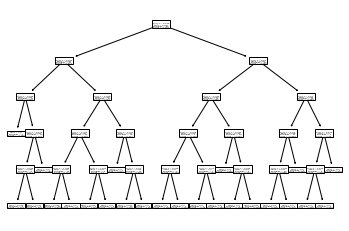

In [31]:
tree.plot_tree(regr_2) 
plt.show()

Como siempre, pueden exportar el diagrama a un documento

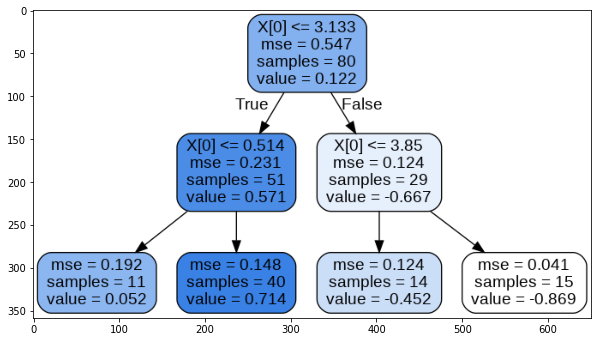

In [32]:
tree.export_graphviz(
regr_1,
out_file="reg_tree.dot",
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng reg_tree.dot -o reg_tree.png

#Ploteamos el png
img = cv2.imread('reg_tree.png')
plt.figure(figsize = (10, 10))
plt.imshow(img)

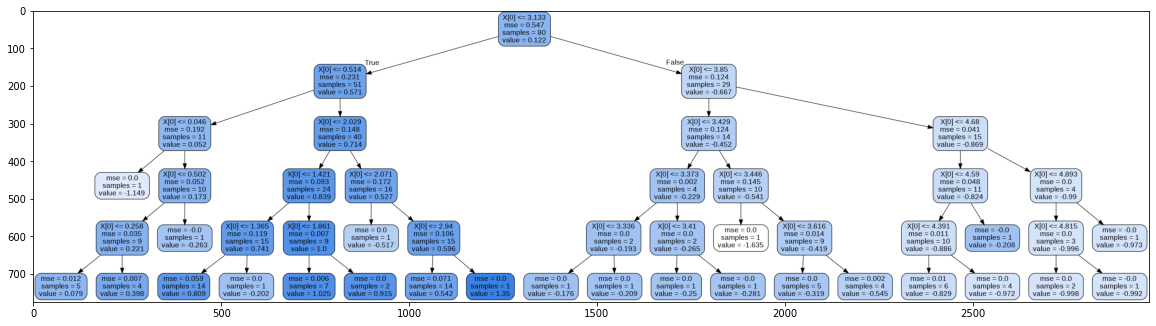

In [34]:
tree.export_graphviz(
regr_2,
out_file="reg_tree.dot",
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng reg_tree.dot -o reg_tree.png

#Ploteamos el png
img = cv2.imread('reg_tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

**EJERCICIO: Traten de usar un DT en el dataset de California y vean que hace el overfitting alli**